In [17]:
import numpy as np
import matplotlib.pyplot as plt
import field
import spatial
import timesteppers
import scipy.sparse.linalg as spla
from scipy import sparse

from timesteppers import *

from field import *
from spatial import FiniteDifferenceUniformGrid

%matplotlib inline

### $ \frac{\partial p}{\partial t} = - \frac{\partial}{\partial x} [ \mu(x,t) p(x,t) ] + \frac{\partial^2}{\partial x^2} [ D(x,t) p(x,t) ]$

In [43]:
class FP_diffusion_split:
    
    def __init__(self, X, dD_p_dx2):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain
        
        pt = Field(self.domain)
        
        LHS = pt - dD_p_dx2
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        self.F_ops = [0*p]        
    
class FP_advection_split:
    
    def __init__(self, X, dmu_p_dx):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain

        pt = Field(self.domain)
        
        LHS = pt + dmu_p_dx
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        self.F_ops = [0*p]        
    
class FokkerPlanck_1D:
    
    def __init__(self, X, mu, D, spatial_order=4):
        '''
        p ~ Fields
        mu, D ~ Arrays
        '''
        self.X = X
        self.p = self.X.field_list[0]
        
        self.domain = self.p.domain

        pt = Field(self.domain)
         
        # generate derivatives

        dmu_p_dx = FiniteDifferenceUniformGrid(1, spatial_order, p*mu)
        dD_p_dx2 = FiniteDifferenceUniformGrid(2, spatial_order, p*D)
        
        
        self.operators = [FP_diffusion_split(self.X, dmu_p_dx),
                          FP_advection_split(self.X, dD_p_dx2)]
            
            
        self.ts_list   = [CrankNicolson(self.operators[0],axis=0),
                          PredictorCorrector(self.operators[1])]     
        
        self.t = 0.
        self.iter = 0
        
    def step(self, dt):
        # take a step
        # update self.t and self.iter
        
        # diffusive terms commute, only have to strang split the other terms
        self.ts_list[1].step(dt/2.)
        self.ts_list[0].step(dt)
        self.ts_list[1].step(dt/2.)
            
        
        # update self.t and self.iter
        self.t += dt
        self.iter += 1        

In [52]:
resolution = 100
alpha = .5
spatial_order = 2

grid = field.UniformPeriodicGrid(resolution,2*np.pi)
domain = field.Domain([grid])
x = domain.values()

p = field.Field(domain)
X = field.FieldSystem([p])

r = np.array([x])-np.pi
IC = np.exp(-r**2*16)
p.data[:] = IC

mu = field.Array(domain,np.zeros(p.data.shape))
D = field.Array(domain,.01*np.ones(p.data.shape))

diff = FokkerPlanck_1D(X,mu,D)

tmax = 1-1e-5

dt = alpha * grid.dx

while diff.t < tmax:
    diff.step(dt)

C:\Users\Lindsey\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


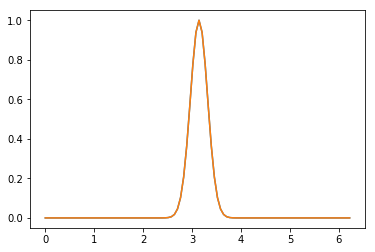

In [53]:
plt.plot(x[0],p.data)
plt.plot(x[0],IC[0][0])

In [51]:
IC[0][0] - p.data

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])